Now we need to check if we can calculate the optical path length difference in a simplified potential to obtain the phase change in the electron wave. We then need to check if we can calculate the phase difference by integrating the potential our electron passes through. We will try and do this for an electron with a long wavelength so we can easily plot the wavelength and phase shift as the electron refracts through the potential. We will also try and use a simple linear potential. 

In [2]:
import sympy as sp
from sympy.core.numbers import pi
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, e, m_e, h
import numba
from numbalsoda import dop853, lsoda, lsoda_sig
from numba import njit, cfunc
import matplotlib.ticker as plticker

%matplotlib widget


Again set up constants and sympy symbols, and define the equation in sympy, and make a lambda function out of it.

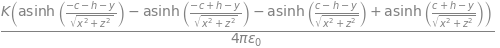

In [3]:
#Initialise printing
sp.init_printing()

#Create mathematical symbols
x, y, z = sp.symbols('x y z', real = True)

e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0 #8.85418782e-12 #permittivity unit F/m
eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

K_val = 3.31 #unit e/nm - convert to coulombs per m? 
K_val_SI = (3.31*abs(e))/1e-9 #C/m

x, y, z, K, eps_0, c, h = sp.symbols('x y z K epsilon_0 c h')
a, b = sp.symbols('a b')

phi_wires_pozzi = (K/(4*pi*eps_0))*((sp.asinh((c-(y-h))/sp.sqrt(x**2+z**2)))-(sp.asinh((-c-(y-h))/sp.sqrt(x**2+z**2)))+(sp.asinh((-c-(y+h))/sp.sqrt(x**2+z**2)))-(sp.asinh((c-(y+h))/sp.sqrt(x**2+z**2))))
display(phi_wires_pozzi)

c_val = 0.5e-3
gap = 90e-9
h_val = -(c_val+gap)
phi_wires_pozzi_simple = phi_wires_pozzi.subs({K:K_val_SI, eps_0:eps_0_val, pi:np.pi, c:c_val, h:h_val})
phi_wires_pozzi_lambda_simple = sp.lambdify([x, y, z], phi_wires_pozzi_simple, 'numpy')

#Calculate the E-Field so we can plot it. 
Ex = -1*phi_wires_pozzi_simple.diff(x)
Ey = -1*phi_wires_pozzi_simple.diff(y)
Ez = -1*phi_wires_pozzi_simple.diff(z)

E_lambda = sp.lambdify([x, y, z], [Ex, Ey, Ez], 'numpy')

Plot the view of the electron as it moves towards the potential in the x-y plane. 

Text(0, 0.5, 'y (m)')

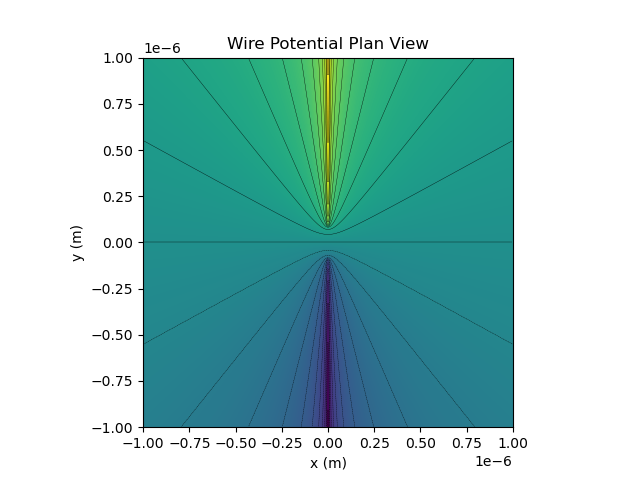

In [4]:
z_ = np.linspace(-1, 1, 1000)
plan_figure, plan_ax = plt.subplots()

scale = 1000e-9
x_line, xstep = np.linspace(-scale, scale, 300, retstep = True)
y_line, ystep = np.linspace(-scale, scale, 300, retstep = True)
x_grid, y_grid = np.meshgrid(x_line, y_line)
z_grid = 0*np.ones(x_grid.shape)

potential_image = phi_wires_pozzi_lambda_simple(x_grid, y_grid, 0)
plan_ax.imshow(potential_image, extent=[-scale, scale, -scale, scale])
plan_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent=[-scale, scale, -scale, scale], origin = 'upper')
plan_ax.set_title('Wire Potential Plan View')
plan_ax.set_xlabel('x (m)')
plan_ax.set_ylabel('y (m)')

Plot a side view of the potential 

Text(0, 0.5, 'y (m)')

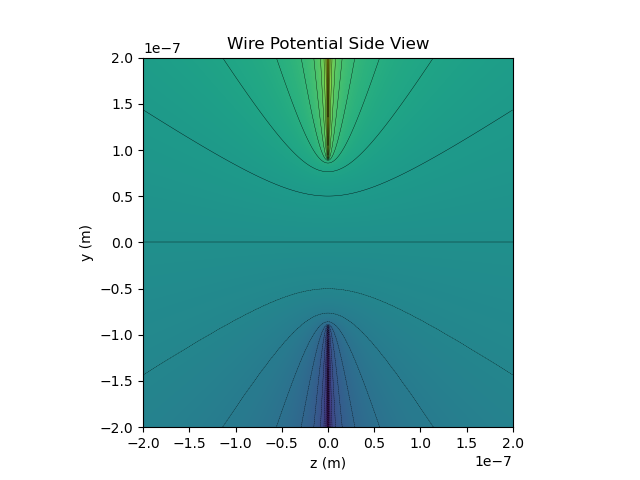

In [5]:
zy_figure, zy_ax = plt.subplots()
z_line, zstep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
y_line, ystep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
z_grid, y_grid = np.meshgrid(y_line, z_line)
x_grid = 0*np.ones(y_grid.shape)
potential_image = phi_wires_pozzi_lambda_simple(x_grid, y_grid, z_grid)
zy_ax.imshow(potential_image, extent=[-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.set_title('Wire Potential Side View')
zy_ax.set_xlabel('z (m)')
zy_ax.set_ylabel('y (m)')

Plot the E-Fields

Text(0, 0.5, 'x (m)')

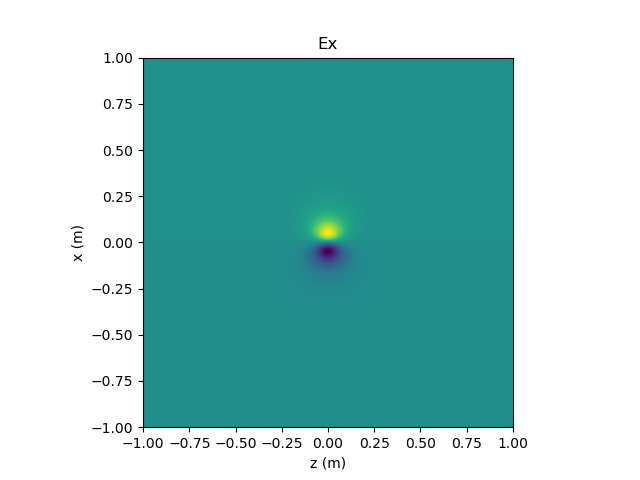

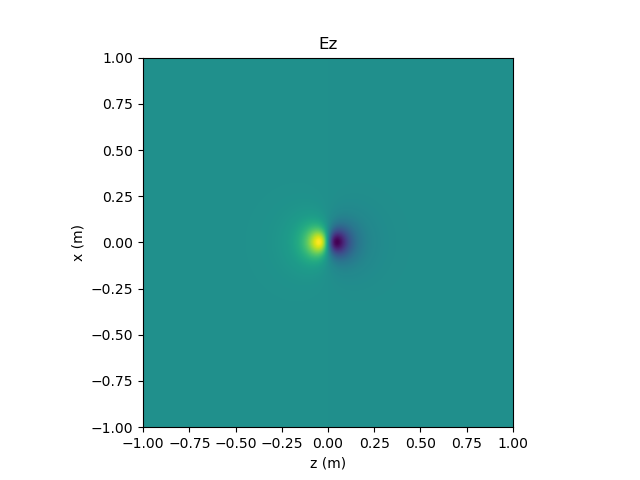

In [6]:
Ex_figure, Ex_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[0]
Ex_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ex_ax.set_title('Ex')
Ex_ax.set_xlabel('z (m)')
Ex_ax.set_ylabel('x (m)')

Ez_figure, Ez_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[2]
Ez_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ez_ax.set_title('Ez')
Ez_ax.set_xlabel('z (m)')
Ez_ax.set_ylabel('x (m)')

Again make our ODE solver equation

In [7]:
def odedopri(f,  x0,  y0,  x1,  tol,  hmax,  hmin,  maxiter, args=()):
    a21 = (1.0/5.0)
    a31 = (3.0/40.0)
    a32 = (9.0/40.0)
    a41 = (44.0/45.0)
    a42 = (-56.0/15.0)
    a43 = (32.0/9.0)
    a51 = (19372.0/6561.0)
    a52 = (-25360.0/2187.0)
    a53 = (64448.0/6561.0)
    a54 = (-212.0/729.0)
    a61 = (9017.0/3168.0)
    a62 = (-355.0/33.0)
    a63 = (46732.0/5247.0)
    a64 = (49.0/176.0)
    a65 = (-5103.0/18656.0)
    a71 = (35.0/384.0)
    a72 = (0.0)
    a73 = (500.0/1113.0)
    a74 = (125.0/192.0)
    a75 = (-2187.0/6784.0)
    a76 = (11.0/84.0)
    c2 = (1.0 / 5.0)
    c3 = (3.0 / 10.0)
    c4 = (4.0 / 5.0)
    c5 = (8.0 / 9.0)
    c6 = (1.0)
    c7 = (1.0)
    b1 = (35.0/384.0)
    b2 = (0.0)
    b3 = (500.0/1113.0)
    b4 = (125.0/192.0)
    b5 = (-2187.0/6784.0)
    b6 = (11.0/84.0)
    b7 = (0.0)
    b1p = (5179.0/57600.0)
    b2p = (0.0)
    b3p = (7571.0/16695.0)
    b4p = (393.0/640.0)
    b5p = (-92097.0/339200.0)
    b6p = (187.0/2100.0)
    b7p = (1.0/40.0)
    x = x0
    y = y0
    h = hmax
    X = np.zeros(maxiter)
    X[0] = x0
    Y = np.zeros((maxiter, len(y0)))
    Y[0] = y0
    
    #We need a special step counter because the ODE dormand prince 
    #method will do a step again with a smaller step size if the error is too large
    step = 1
    for i in range(maxiter):
       # /* Compute the function values */
       K1 = f(x,       y, *args)
       K2 = f(x + c2*h, y+h*(a21*K1), *args)
       K3 = f(x + c3*h, y+h*(a31*K1+a32*K2), *args)
       K4 = f(x + c4*h, y+h*(a41*K1+a42*K2+a43*K3), *args)
       K5 = f(x + c5*h, y+h*(a51*K1+a52*K2+a53*K3+a54*K4), *args)
       K6 = f(x + h, y+h*(a61*K1+a62*K2+a63*K3+a64*K4+a65*K5), *args)
       K7 = f(x + h, y+h*(a71*K1+a72*K2+a73*K3+a74*K4+a75*K5+a76*K6), *args)
       error = abs((b1-b1p)*K1+(b3-b3p)*K3+(b4-b4p)*K4+(b5-b5p)*K5 +
                   (b6-b6p)*K6+(b7-b7p)*K7)
       #Error in X controls tolerance
       error = max(error)
       # error control
       if error != 0.0:
           delta = 0.84 * pow(tol / error, (1.0/5.0))
       else:
           delta = np.inf
       if (error < tol):
          x = x + h
          X[step] = x
          y = y + h * (b1*K1+b3*K3+b4*K4+b5*K5+b6*K6)
          Y[step, :] = y
          step+=1
       if (delta <= 0.1):
          h = h * 0.1
       elif (delta >= 4.0):
          h = h * 4.0
       else:
          h = delta * h
       if (h > hmax):
          h = hmax
       if (x >= x1):
          print('reached end')
          break
       elif (x + h > x1):
          h = x1 - x
       elif (h < hmin):
          print('Below hmin')
          break
    return X, Y, step

And make our potential function that we need to put into our ODE solver

In [8]:
def make_potential_and_efield(phi, phi_0, x, y, z, eps):
    
    phi_hat = (phi_0-phi)*(1+eps*(phi_0-phi))
    
    #Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
    dphi_hat_wires_electron_dx = phi_hat.diff(x)
    dphi_hat_wires_electron_dy = phi_hat.diff(y)
    dphi_hat_wires_electron_dz = phi_hat.diff(z)

    phi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], phi_hat, 'numpy'), nopython = True)
    dphi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], [dphi_hat_wires_electron_dx, dphi_hat_wires_electron_dy, dphi_hat_wires_electron_dz], 'numpy'), nopython = True)
    
    return phi_hat_wires_electron_lambda, dphi_hat_wires_electron_lambda

Trajectory equation of motion from Hawkes. We have a slower version from 

In [9]:
@numba.jit(nopython = True, cache=True)
def trajectory_equation_of_motion(z, x, phi_hat_lambda, dphi_hat_lambda, phi_hat_0):
    
    p = np.sqrt(1+x[1]**2+x[3]**2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield

    return [x[1], (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z), x[3], (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z), (phi_hat/phi_hat_0)**(1/2)*p] #evaluate the velocities and accelerations, [vx, ax, vy, ay]

#Define acceleration potential of electron
phi_0 = 2e5 #unit V #2e5

phi_hat_lambda, dphi_hat_lambda = make_potential_and_efield(phi_wires_pozzi_simple, phi_0, x, y, z, eps)

@cfunc(lsoda_sig)
def trajectory_equation_of_motion_numba(z, x, dx, phi_hat_0):
    
    p = (1+x[1]**2+x[3]**2)**(1/2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield

    dx[0] = x[1]
    dx[1] = (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z)
    dx[2] = x[3]
    dx[3] = (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z)
    dx[4] = (phi_hat/phi_hat_0[0])**(1/2)*p


Perform ray tracing with our method and with scipy. 

In [10]:
from scipy.integrate import solve_ivp
x0 = np.array([0, 0, 0, 0, 0]) #x, x', y, y', opl
z0 = -1. #Initial z plane
zF = 1. #Final z plane

# integration parameters
params = {'max_step': np.inf,
          'rtol': 1e-13,
          'atol': 1e-20,
          }

phi_hat_lambda_0 = phi_hat_lambda(x0[0], x0[2], z0)

rhs = trajectory_equation_of_motion_numba #make_dop853_func(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0)
funcptr = rhs.address

In [11]:

# use solve_ivp to solve 
sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                method='DOP853', **params,
                args=(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0), dense_output=True)

In [12]:
z_orig = sol.t
x_orig = sol.y

z_precise = np.linspace(z0, zF, int(1e7))
x_precise = sol.sol(z_precise)

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)

wavelengths_norm = (wavelengths-min(wavelengths))/(max(wavelengths)-min(wavelengths))
colors = plt.cm.jet(wavelengths_norm)

print(x_orig[4][-1]/wavelengths[0])



797469191373.4653


Plot path of ray in z-y (ray should not see any deflection) and z-x plane (ray should be deflected significantly)

In [13]:

sol_numba_dop, success = dop853(funcptr, x0, t_eval = np.array([-1.,  1.]), data = np.array([phi_hat_lambda_0]), rtol = 1.0e-13, atol = 1.0e-20)
sol_numba_lsoda, success = lsoda(funcptr, x0, t_eval = np.array([-1.,  1.]), data = np.array([phi_hat_lambda_0]), rtol = 1.0e-13, atol = 1.0e-20)

In [14]:
print(sol_numba_dop[-1][-1]/wavelengths[0])
print(sol_numba_lsoda[-1][-1]/wavelengths[0])

797469191373.4653
797469191373.4651


X positional deflection (scipy) (m): 0.0
Y positional deflection (scipy) (m): 0.0005194505542023379


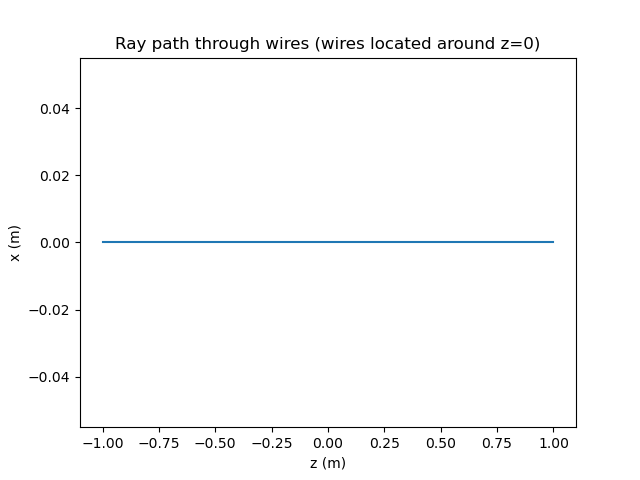

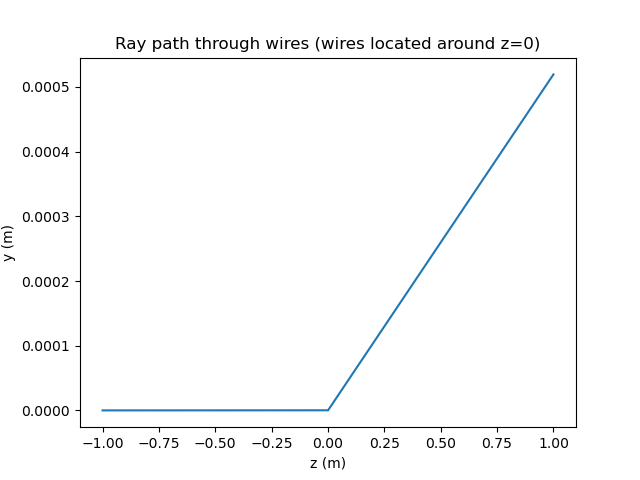

In [15]:
plt.figure()
plt.plot(sol.t, sol.y[0])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

plt.figure()
plt.plot(sol.t, sol.y[2])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('y (m)')


print('X positional deflection (scipy) (m):', sol.y[0][-1])
print('Y positional deflection (scipy) (m):', sol.y[2][-1])


Plot the "wavelength" of the electron as it moves through the potential. For now I have not been too carful about the sign of every value sign, but I will have to consider it again later. Now I just need to check if I can calculate a phase difference. 

2.5079340450547974e-12 2.5079196712554643e-12


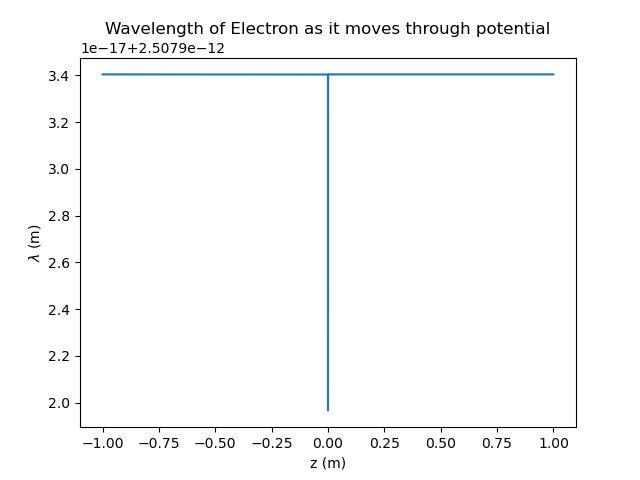

In [16]:
plt.figure()
plt.title('Wavelength of Electron as it moves through potential')
plt.xlabel('z (m)')
plt.ylabel('$\lambda$ (m)')
plt.plot(z_precise, wavelengths)
print(max(wavelengths), min(wavelengths))


Now we need to perform the optical path length calculation. I will keep this simple, and only solve the basic optical path length integral: 

In [17]:
def opl(x, y, z, x_prime, y_prime, phi_hat_lambda, wavelengths):
    phi_hat_lambda0 = phi_hat_lambda(x[0], y[0], z[0])
    dx, dy, dz = np.diff(x), np.diff(y), np.diff(z) #get the differences between each coordinate
    ds = np.sqrt(dx**2+dy**2+dz**2)
    
    #s = np.cumsum(np.pad(np.sqrt(deltax**2+deltay**2+deltaz**2), (1, 0), "constant")) #path length calculation, with 0 appended to the start
    rho = np.sqrt(1+x_prime[:-1]**2+y_prime[:-1]**2)
    opl_ds = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*ds)
    opl_dz = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*rho*dz)
    opl_length_over_wavelength = np.sum(ds/wavelengths[:-1])*wavelengths[0]

    return opl_ds, opl_dz, opl_length_over_wavelength

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_orig[0], x_orig[2], z_orig))**(1/2)

opl_from_ode = x_orig[4][-1]
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_orig[0], x_orig[2], z_orig, x_orig[1], x_orig[3], phi_hat_lambda, wavelengths)

print('OPL ds =' , opl_ds)
print('OPL dz =' , opl_dz)
print('OPL length/wavelength =' , opl_length_over_wavelength)
print('OPL from ODE =' , x_orig[4][-1], '\n')

print('Num Wavelengths - OPL ds =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz =' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength =' , opl_length_over_wavelength/wavelengths[0])
print('Num Wavelengths - OPL from ODE = ' , x_orig[4][-1]/wavelengths[0], '\n')

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_precise[0], x_precise[2], z_precise, x_precise[1], x_precise[3], phi_hat_lambda, wavelengths)

print('OPL ds (precise) =' , opl_ds)
print('OPL dz (precise) =' , opl_dz)
print('OPL length/wavelength (precise) =' , opl_length_over_wavelength, '\n')

print('Num Wavelengths - OPL ds (precise) =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz (precise) = ' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength (precise) = ' , opl_length_over_wavelength/wavelengths[0])



OPL ds = 2.000000134928634
OPL dz = 2.0000001349278804
OPL length/wavelength = 2.000000134928634
OPL from ODE = 2.0000001349278334 

Num Wavelengths - OPL ds = 797469191373.7847
Num Wavelengths - OPL dz = 797469191373.4841
Num Wavelengths - OPL length/wavelength = 797469191373.7847
Num Wavelengths - OPL from ODE =  797469191373.4653 

OPL ds (precise) = 2.0000001349276846
OPL dz (precise) = 2.0000001349276713
OPL length/wavelength (precise) = 2.000000134927718 

Num Wavelengths - OPL ds (precise) = 797469191373.406
Num Wavelengths - OPL dz (precise) =  797469191373.4008
Num Wavelengths - OPL length/wavelength (precise) =  797469191373.4193


It's hard to know if we can trust our calculation of the phase to more than 1 decimal place, but we don't have much of a choice. I can't really eek out any more precision without doing a lot more thinking and rearranging the equations to be non dimensionalised I think (even then I don't know if it would work, the difference in scales is the challenge here). Now we can calculate a wavefront image with a parallelised code. 

In [18]:
n = np.arange(0, 10000)

for num in n:
    if abs(np.sqrt(num*12) - round(np.sqrt(num*12))) < 1e-14:
        print(num, np.sqrt(num*12))

0 0.0
3 6.0
12 12.0
27 18.0
48 24.0
75 30.0
108 36.0
147 42.0
192 48.0
243 54.0
300 60.0
363 66.0
432 72.0
507 78.0
588 84.0
675 90.0
768 96.0
867 102.0
972 108.0
1083 114.0
1200 120.0
1323 126.0
1452 132.0
1587 138.0
1728 144.0
1875 150.0
2028 156.0
2187 162.0
2352 168.0
2523 174.0
2700 180.0
2883 186.0
3072 192.0
3267 198.0
3468 204.0
3675 210.0
3888 216.0
4107 222.0
4332 228.0
4563 234.0
4800 240.0
5043 246.0
5292 252.0
5547 258.0
5808 264.0
6075 270.0
6348 276.0
6627 282.0
6912 288.0
7203 294.0
7500 300.0
7803 306.0
8112 312.0
8427 318.0
8748 324.0
9075 330.0
9408 336.0
9747 342.0


In [19]:
print(dop853)

CPUDispatcher(<function dop853 at 0x000001C905C49240>)


In [20]:
 np.linspace(-1., 1., 3)

array([-1.,  0.,  1.])

In [21]:
n = 12*12
num_along_dim = int(np.sqrt(n))

x0 = np.linspace(-1e-3, 1e-3, num_along_dim, np.float64)
y0 = np.linspace(-1e-3, 1e-3, num_along_dim, np.float64)
grid = np.array(np.meshgrid(x0, y0))
pos_0 = grid.reshape(2, n).T

z_eval = np.linspace(-1., 1., 3)

rhs = trajectory_equation_of_motion_numba
funcptr = rhs.address

@numba.njit(parallel=True)
def main(n, pos_0, phi_hat_lambda_0):
    
    print(n)
    x_out = np.empty((n,len(z_eval)), np.float64)
    y_out = np.empty((n,len(z_eval)), np.float64)
    opl_out = np.empty((n,len(z_eval)), np.float64)

    n_threads = 12 #Number of threads on laptop cpu
    thread_block_size = int(n/n_threads)
    macro_block_size = 12
    macro_blocks = int(thread_block_size/macro_block_size)
    
    for thread in numba.prange(n_threads):
        thread_idx = thread*thread_block_size
        
        for macro_block in range(macro_blocks):
                #get starting index for the block of rays of each macroblock in a thread.
                macro_block_idx = macro_block*macro_block_size
                
                #combine the starting index of the thread and macroblock
                idx_start = thread_idx + macro_block_idx
                
                for j in range(macro_block_size):
                    u0 = np.empty((5,), np.float64)
                    
                    u0[0] = pos_0[idx_start+j, 0]
                    u0[1] = 0.
                    u0[2] = pos_0[idx_start+j, 1]
                    u0[3] = 0.
                    u0[4] = 0.
                    
                    usol, success = lsoda(funcptr, u0, z_eval, data = phi_hat_lambda_0, rtol = 1.0e-13, atol = 1.0e-20)
                    
                    x_out[idx_start+j] = usol[:,0]
                    y_out[idx_start+j] = usol[:,2]
                    opl_out[idx_start+j] = usol[:,4]
            
    return x_out, y_out, opl_out

x_out, y_out, opl_out = main(n, pos_0, np.array([phi_hat_lambda_0]))

144


100
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.001
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098
-0.00098

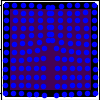

In [39]:

my_dpi = 100
scale = 0.001
pixels = 25
image = np.zeros((pixels, pixels ))
fig, ax = plt.subplots(figsize=(float(image.shape[1])/my_dpi,float(image.shape[0])/my_dpi), dpi=my_dpi)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

pixel_size = (scale*2)/pixels

myInterval=pixel_size
loc = plticker.MultipleLocator(base=myInterval)
#ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)

ax.set_xticks(np.linspace(-scale, scale, 3))
ax.set_yticks(np.linspace(-scale, scale, 3))

# Add the grid
#ax.grid(which='major', axis='both', linestyle='-', lw = 2, color = 'k')


# Add the image
ax.imshow(image, extent = [-scale, scale, -scale, scale])
#print(ax.get_xlim())
nx=abs(int(float(scale-(-scale))/float(myInterval)))
ny=abs(int(float(scale-(-scale))/float(myInterval)))
print(nx)

for j in range(ny):
    y=j*myInterval-scale
    for i in range(nx):
        x = j*myInterval-scale
        ax.plot([x, x], [-scale, scale], 'k.')
        ax.plot([-scale, scale], [y, y], 'k.')


ax.plot(x_out[:, -1], y_out[:, -1], '.b')

In [ ]:

extent_scale = 0.001
pixels = 128
pixel_size = (extent_scale*2)/pixels

pos_x_bottom_left = extent_scale+x_out[:, -1]
pos_y_bottom_left = extent_scale+y_out[:, -1]

print(pos_x_bottom_left)
print(pos_y_bottom_left)

pixel_x_centred = np.floor(((((pos_x_bottom_left)/(extent_scale*2))*(pixels)))).astype(np.int32)
pixel_y_centred = np.floor(((((pos_y_bottom_left)/(extent_scale*2))*(pixels)))).astype(np.int32)

complex_image = np.zeros((pixels, pixels), dtype = np.float64)
complex_image[pixel_y_centred, pixel_x_centred] = complex_phase

plt.figure()
plt.imshow(complex_image, extent = (-extent_scale, extent_scale, -extent_scale, extent_scale), origin = 'lower')
#plt.plot(pos_x_bottom_left-extent_scale, pos_y_bottom_left-extent_scale, '.', markersize = 2)
plt.savefig('image_text.png', dpi = 1000)
